In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

In [2]:
# Установка сида для TensorFlow
tf.random.set_seed(42)

# Знакомство с данными, обработка и анализ

В данной работе используется следующий набор данных о погоде: [Daily Climate time series data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data).

В этот набор данных включены замеры 4 метеорологических показателей (температура воздуха, влажность, скорость ветра и атмосферное давление), выполняющиеся каждый день с 2013 года по 2017. В обучающей выборке присутствуют данные с 2013 года по 2016. В тестовой же выборке данные представлены только за первые четыре месяца 2017 года.

In [3]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

Посмотрим на имеющиеся данные.

In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [6]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
df_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [8]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [9]:
df_test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


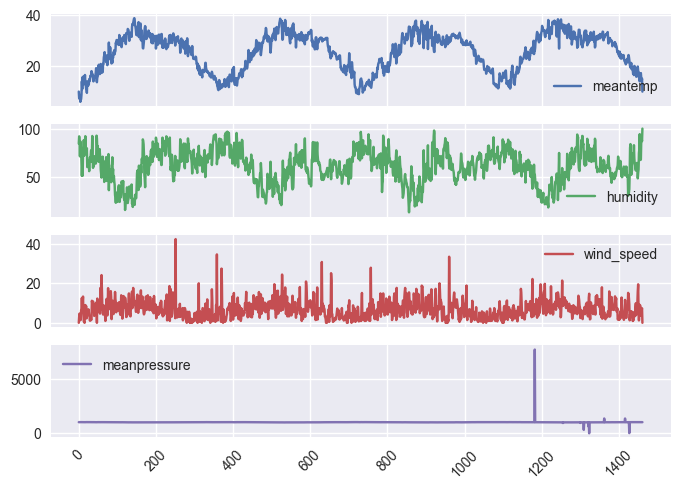

In [10]:
df.plot(subplots=True, rot=45);

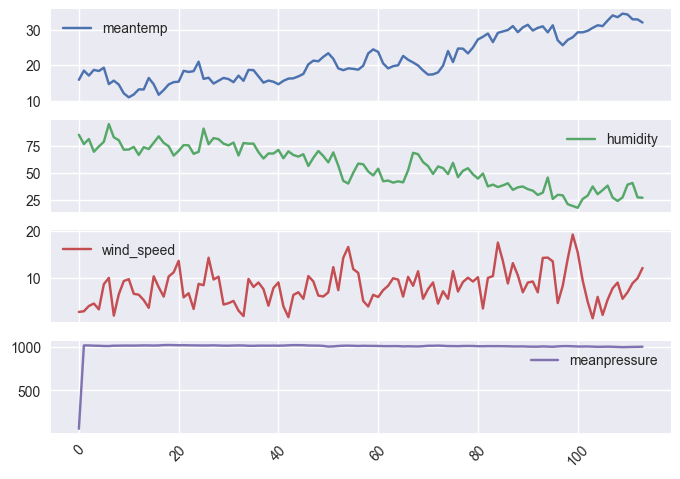

In [11]:
df_test.plot(subplots=True, rot=45);

Видим, что в столбце `meanpressure` присутствуют явные выбросы.

![Диаграмма размаха](./boxplot.png)

При помощи написанной функции `remove_outliers_iqr` удалим выбросы (а точнее заменим их на медианные значения).

In [12]:
def remove_outliers_iqr(data, replacement):
    
    # Вычисляем первый квартиль (25-й перцентиль)
    q1 = np.percentile(data, 25)
    # Вычисляем третий квартиль (75-й перцентиль)
    q3 = np.percentile(data, 75)
    
    # Вычисляем межквартильный размах (IQR)
    iqr = q3 - q1
    
    # Вычисляем нижнюю и верхнюю границы для определения выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Заменяем выбросы на заданное значение
    # np.where проверяет условия: если элемент меньше нижней границы или больше верхней границы, 
    # он заменяется на значение replacement, иначе оставляется без изменений
    replaced_data = np.where((data < lower_bound) | (data > upper_bound), replacement, data)
    
    return replaced_data

In [13]:
meanpressure_without_outliers = remove_outliers_iqr(df['meanpressure'], df['meanpressure'].median())
df['meanpressure'] = meanpressure_without_outliers

meanpressure_test_without_outliers = remove_outliers_iqr(df_test['meanpressure'], df_test['meanpressure'].median())
df_test['meanpressure'] = meanpressure_test_without_outliers

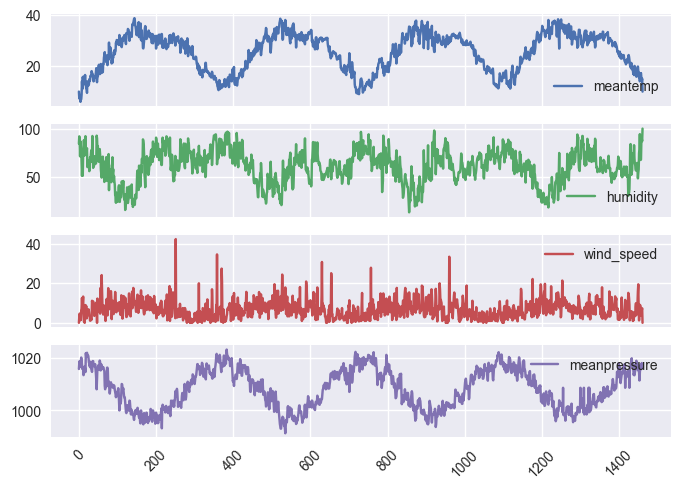

In [14]:
df.plot(subplots=True, rot=45);

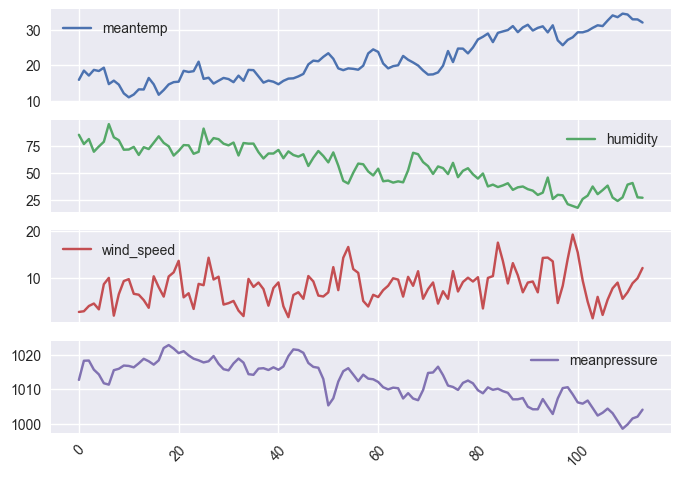

In [15]:
df_test.plot(subplots=True, rot=45);

Теперь выбросы отсутствуют.

Установим столбец `date` в качестве индекса, это позволит в дальнейшем легче выполнить анализ данных.

In [16]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

Построим матрицу корреляции, чтобы обнаружить зависимости между переменными.

In [17]:
correlation_matrix = df.corr()

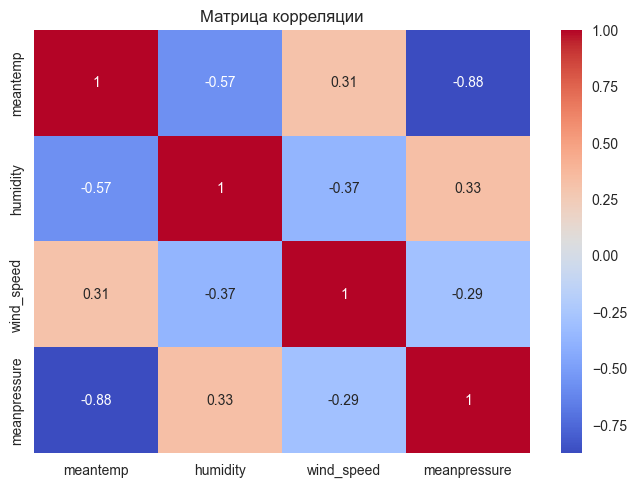

In [18]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

![Коэффициенты корреляции](./correlation_coefs.jpg)

Видим, что между температурой (`meantemp`) и давлением (`meanpressure`) наблюдается сильная отрицательная корреляция. Это означает, что при увеличении одной переменной, другая переменная уменьшается. Между температурой и влажностью (`humidity`) также существует заметная отрицательная корреляция, а между температурой и скоростью ветра (`wind_speed`) — умеренная положительная корреляция. Таким образом, можно заключить, что давление и влажность являются наиболее значимыми переменными для предсказания температуры.

Выполним ресемплирование временного ряда с ежемесячной частотой.

In [19]:
# Ресемплируем данные df с ежемесячной частотой, используя конец месяца ('ME'), и вычисляем среднее значение для каждого месяца
monthly_resampled_data = df.resample('ME').mean()

In [20]:
# Преобразуем индекс месячных данных в строковый формат 'МММ ГГГГ' (например, 'Jan 2020') для удобного отображения
months = monthly_resampled_data.index.strftime('%b %Y')

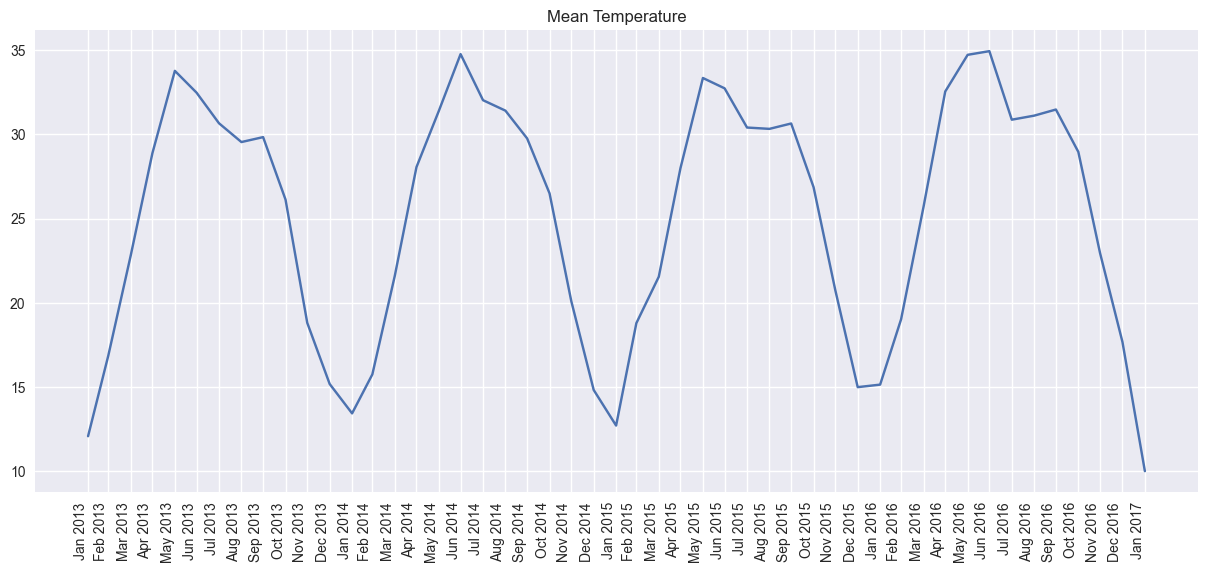

In [21]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])

ax.plot(monthly_resampled_data['meantemp'])
ax.set_xticks(monthly_resampled_data.index)
ax.set_xticklabels(months, rotation=90, ha='right')

plt.title('Mean Temperature');

Выполним сезонное разложение временного ряда средней температуры с помощью функции `seasonal_decompose`. Это разложение разделяет временной ряд на три компоненты:

1. Тренд — долгосрочное движение данных.
2. Сезонность — повторяющиеся временные закономерности.
3. Шум (остаток) — случайные колебания, не объясненные трендом или сезонностью.

In [22]:
decomposed = seasonal_decompose(monthly_resampled_data['meantemp'])

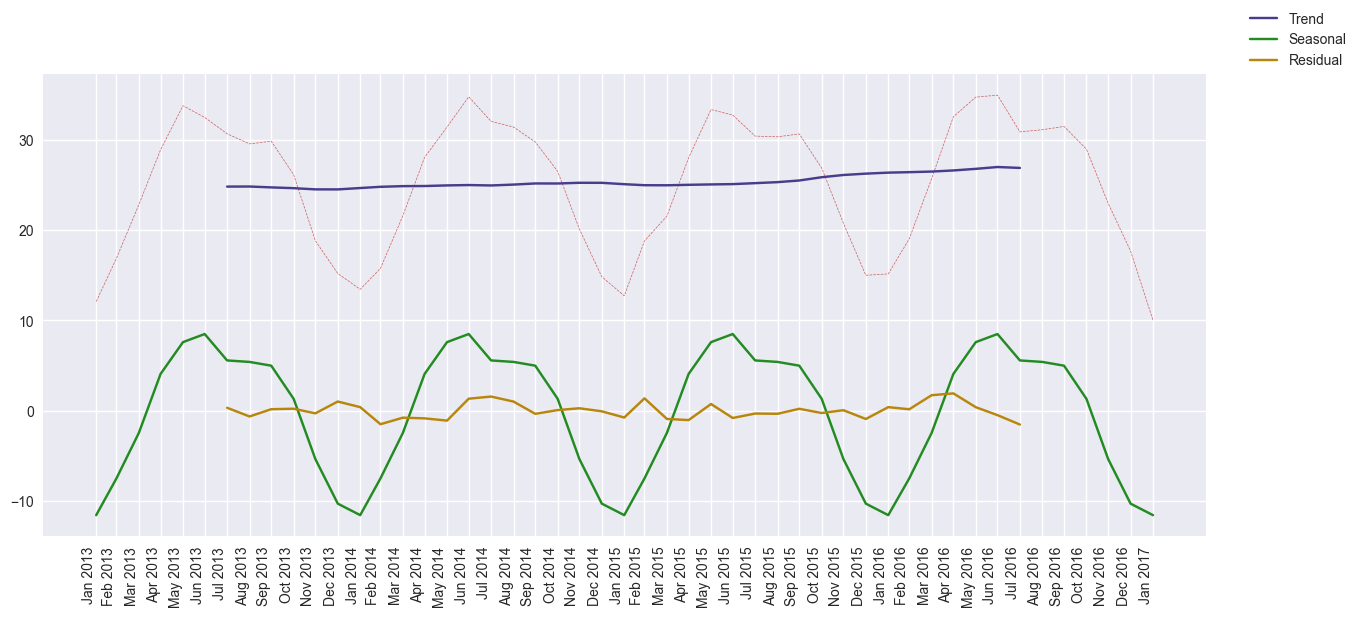

In [23]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])

ax.plot(monthly_resampled_data['meantemp'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_xticks(monthly_resampled_data.index)
ax.set_xticklabels(months, rotation=90, ha='right')

fig.legend();

На графике выше можно заметить небольшой восходящий тренд. Помимо этого, данные демонстрируют выраженную сезонность: температура ежегодно повышается, достигая своего пика летом, а затем постепенно снижается.

Таким образом, разложение временных рядов на компоненты позволяет глубже анализировать временные ряды. Этот метод помогает понять структуру данных и использовать полученную информацию для различных целей, таких как прогнозирование и принятие решений. Пример с погодой демонстрирует его практическую ценность: мы можем обнаружить долгосрочный тренд глобального потепления и ежегодные сезонные изменения температуры, что важно для климатических исследований. Такой подход можно применить и к другим временным рядам, например, в экономике или здравоохранении, для анализа и улучшения понимания данных.

# Точечное прогнозирование температуры на следующий день на основе одномерного временного ряда

## Подготовка данных для обучения рекуррентных нейронных сетей (SimpleRNN, LSTM, GRU)

Рекуррентная нейронная сеть (РНС) — это тип нейронных сетей, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.

Рекуррентные нейронные сети принимают на вход последовательность векторов в виде двумерного тензора с формой `(временные_интервалы, входные_признаки)`. Функция `generate_data` возвращает временные интервалы для обучения модели, позволяя использовать различные конфигурации для генерации выборки. Например, можно осуществлять точечное прогнозирование (предсказание одного значения) или интервальное прогнозирование (предсказание нескольких значений одновременно).

In [24]:
def generate_data(dataset, target, start_index, end_index, history_size,
                  target_size, step, single_step=False):
    
    """
    Возвращает временные интервалы для обучения модели.

    Параметры:
    dataset (array-like): Массив данных.
    target (array-like): Массив целевых значений.
    start_index (int): Начальный индекс для генерации данных.
    end_index (int): Конечный индекс для генерации данных.
    history_size (int): Размер последнего временного интервала.
    target_size (int): Аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать.
    step (int): Шаг между временными точками.
    single_step (bool): Флаг для использования одного шага в метках или нескольких.

    Возвращает:
    tuple: Кортеж из двух массивов: данные и метки.
    """
    
    data = []
    labels = []
    
    # Начинаем сдвиг с учетом истории
    start_index += history_size
    # Если end_index не задан, устанавливаем его в конец датасета минус target_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    # Цикл для генерации данных и меток
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) # Индексы для выборки данных
        data.append(dataset[indices]) # Добавляем срез данных в список
        
        if single_step:
            labels.append(target[i+target_size]) # Добавляем метку для одного шага
        else:
            labels.append(target[i:i+target_size]) # Добавляем метки для нескольких шагов
            
    return np.array(data), np.array(labels)

Будем обучать модель, используя только один признак — температуру.

In [25]:
dataset = df[:-1]['meantemp']
dataset = pd.DataFrame(dataset)
data = dataset.values

dataset_test = df_test['meantemp']
dataset_test = pd.DataFrame(dataset_test)
data_test = dataset_test.values

In [26]:
data.shape

(1461, 1)

In [27]:
data_test.shape

(114, 1)

Разделим выборку на обучающую и валидационную.

In [28]:
train_size = int(len(data) * 0.75)
print('Разделение выборки на обучающую и валидационную:', train_size)

Разделение выборки на обучающую и валидационную: 1095


Перед обучением нейронной сети важным шагом является масштабирование данных. Одним из распространённых способов выполнения масштабирования является стандартизация, выполняемая путём вычитания среднего значения и деления на стандартное отклонение для каждого признака. Стандартизация должна выполняться только с использованием обучающих данных, в противном случае произойдет утечка данных.

Выполним стандартизацию данных.

In [29]:
scaler = StandardScaler()
scaler.fit(np.array(data[:train_size]))

scaled_data = scaler.transform(data)
scaled_data_test = scaler.transform(data_test)

In [30]:
print(f'Стандартное отклонение: {scaler.scale_[0]}')
print(f'Среднее значение: {scaler.mean_[0]}')

Стандартное отклонение: 7.407290195875342
Среднее значение: 24.972252668951906


Будем выполнять точечное прогнозирование температуры воздуха на следующий день, используя данные за последнюю неделю.

In [31]:
# Размер последнего временного интервала
PAST_HISTORY = 7
# Аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать
FUTURE_TARGET = 0
# Шаг между временными точками
STEP = 1

# Создание обучающей выборки
x_train, y_train = generate_data(scaled_data, scaled_data, 0,
                                 train_size, PAST_HISTORY,
                                 FUTURE_TARGET, STEP,
                                 single_step=True)

# Создание валидационной выборки
x_val, y_val = generate_data(scaled_data, scaled_data, train_size,
                             None, PAST_HISTORY,
                             FUTURE_TARGET, STEP,
                             single_step=True)

# Создание тестовой выборки
x_test, y_test = generate_data(scaled_data_test, scaled_data_test, 0,
                               None, PAST_HISTORY,
                               FUTURE_TARGET, STEP,
                               single_step=True)

In [32]:
print('Размерность обучающей выборки:', x_train.shape)
print('Размерность валидационной выборки:', x_val.shape)
print('Размерность тестовой выборки:', x_test.shape)

Размерность обучающей выборки: (1088, 7, 1)
Размерность валидационной выборки: (359, 7, 1)
Размерность тестовой выборки: (107, 7, 1)


## Обучение рекуррентных нейронных сетей (SimpleRNN, LSTM, GRU) и оценка результатов

Создадим модели рекуррентных нейронных сетей, используя инструменты фреймворка `Keras`.

In [33]:
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=16,
                              input_shape=x_train.shape[-2:],
                              ),
    tf.keras.layers.Dense(units=1)
])

model_gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units=16,
                        input_shape=x_train.shape[-2:],
                        ),
    tf.keras.layers.Dense(units=1)
])

model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=16,
                         input_shape=x_train.shape[-2:],
                         ),
    tf.keras.layers.Dense(units=1)
])

# Компиляция модели с использованием SimpleRNN
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Компиляция модели с использованием GRU
model_gru.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Компиляция модели с использованием LSTM
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

Выведем структуры моделей.

In [34]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

Будем обучать модели на протяжении 100 эпох, используя валидационную выборку для мониторинга переобучения.

In [37]:
EPOCHS = 100

In [38]:
history_rnn = model_rnn.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2081 - val_loss: 0.1850
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1803 - val_loss: 0.1769
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1721 - val_loss: 0.1728
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1685 - val_loss: 0.1703
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1661 - val_loss: 0.1691
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1646 - val_loss: 0.1687
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1637 - val_loss: 0.1688
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628 - val_loss: 0.1673
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1617 - val_loss: 0.1660
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1609 - val_loss: 0.1661
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 - val_loss: 0.1659
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1

Создадим функцию `plot_train_history` для наглядного отображения значений потерь на этапах обучения и валидации.

In [39]:
def plot_train_history(history, title):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
    plt.plot(epochs, val_loss, 'r', label='Потери на этапе валидации')
    plt.title(title)
    plt.legend()
    
    plt.show()

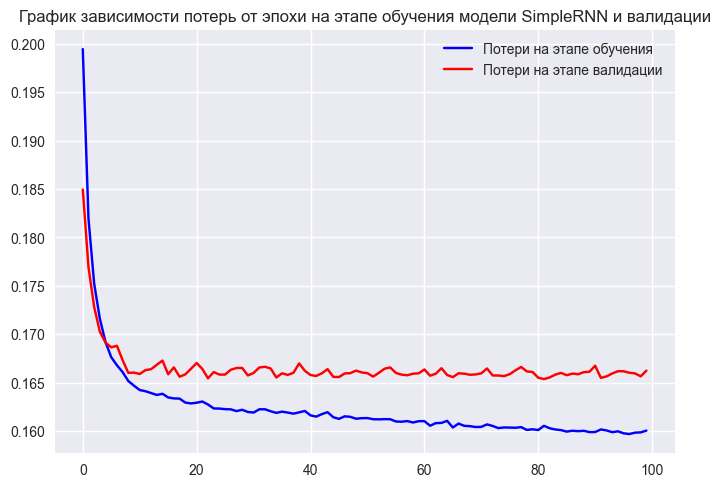

In [40]:
plot_train_history(history_rnn, 'График зависимости потерь от эпохи на этапе обучения модели SimpleRNN и валидации')

Видим, что потери модели SimpleRNN достигли своего минимума, явных признаков переобучения нет, однако присутствуют осцилляции.

Обучим модель GRU.

In [41]:
history_gru = model_gru.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6980 - val_loss: 0.3975
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3170 - val_loss: 0.2034
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2101 - val_loss: 0.1968
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1989 - val_loss: 0.1932
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1955 - val_loss: 0.1912
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1920 - val_loss: 0.1881
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1891 - val_loss: 0.1859
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1865 - val_loss: 0.1835
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1837 - val_loss: 0.1814
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1818 - val_loss: 0.1794
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1795 - val_loss: 0.1781
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

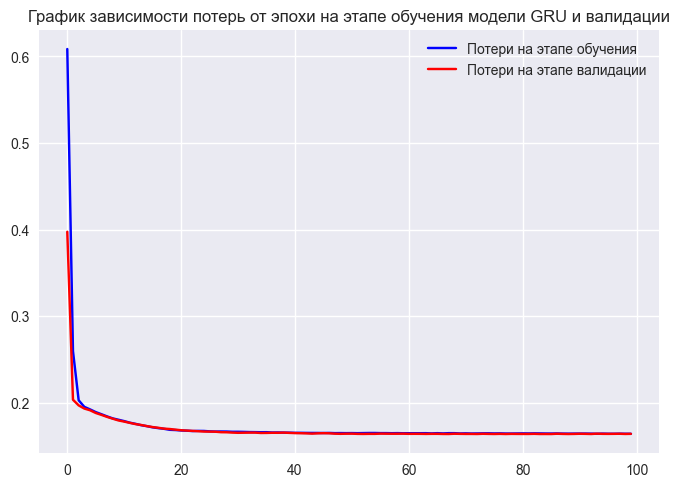

In [42]:
plot_train_history(history_gru, 'График зависимости потерь от эпохи на этапе обучения модели GRU и валидации')

Модель GRU продемонстрировала лучшие результаты по сравнению с простой рекуррентной сетью (SimpleRNN). Потери достигли минимума, признаки переобучения отсутствуют, и колебания практически не наблюдаются.

Теперь обучим сеть LSTM.

In [43]:
history_lstm = model_lstm.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8745 - val_loss: 0.6502
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5401 - val_loss: 0.2869
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2805 - val_loss: 0.2379
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2478 - val_loss: 0.2286
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2352 - val_loss: 0.2228
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2276 - val_loss: 0.2161
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2229 - val_loss: 0.2105
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2172 - val_loss: 0.2067
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2134 - val_loss: 0.2030
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2096 - val_loss: 0.1995
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2059 - val_loss: 0.1968
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

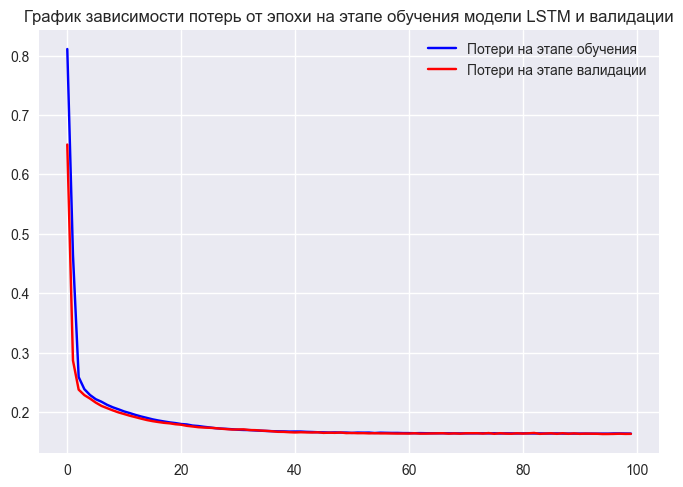

In [44]:
plot_train_history(history_lstm, 'График зависимости потерь от эпохи на этапе обучения модели LSTM и валидации')

LSTM демонстрирует схожие с GRU результаты.

В процессе обучения моделей SimpleRNN, GRU и LSTM удалось достичь значения функции потерь MAE 0.15 (1.11 $^{\circ}C$) на обучающей выборке и 0.16 (1.184 $^{\circ}C$) на валидационной выборке. Признаки переобучения не наблюдаются. Теперь оценим качество обученных рекуррентных нейронных сетей на отложенной выборке, чтобы подтвердить их способность к обобщению.

In [45]:
# Генерация предсказаний для модели SimpleRNN
predictions_rnn = model_rnn.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_rnn = scaler.inverse_transform(predictions_rnn)

# Генерация предсказаний для модели GRU
predictions_gru = model_gru.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_gru = scaler.inverse_transform(predictions_gru)

# Генерация предсказаний для модели LSTM
predictions_lstm = model_lstm.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_lstm = scaler.inverse_transform(predictions_lstm)

In [46]:
# Обратное преобразование масштабированных тестовых значений в исходные значения
y_test = scaler.inverse_transform(y_test)

In [47]:
# Создание DataFrame с предсказаниями и фактическими значениями для модели SimpleRNN
preds_acts_rnn = pd.DataFrame(data={'Predictions':predictions_rnn.flatten(), 'Actuals':y_test.flatten()})

# Создание DataFrame с предсказаниями и фактическими значениями для модели GRU
preds_acts_gru = pd.DataFrame(data={'Predictions':predictions_gru.flatten(), 'Actuals':y_test.flatten()})

# Создание DataFrame с предсказаниями и фактическими значениями для модели LSTM
preds_acts_lstm = pd.DataFrame(data={'Predictions':predictions_lstm.flatten(), 'Actuals':y_test.flatten()})

In [48]:
preds_acts_rnn

,Predictions,Actuals
0,15.436791,15.684211
1,15.377804,14.571429
2,15.005152,12.111111
3,12.091000,11.000000
4,11.895197,11.789474
...,...,...
102,33.303410,34.500000
103,34.294872,34.250000
104,34.309937,32.900000
105,33.015926,32.875000


In [49]:
preds_acts_gru

,Predictions,Actuals
0,15.158508,15.684211
1,15.803313,14.571429
2,14.797942,12.111111
3,12.649087,11.000000
4,11.590444,11.789474
...,...,...
102,33.134136,34.500000
103,34.063526,34.250000
104,33.886185,32.900000
105,32.928734,32.875000


In [50]:
preds_acts_lstm

,Predictions,Actuals
0,15.036667,15.684211
1,15.852180,14.571429
2,14.694628,12.111111
3,12.686811,11.000000
4,11.666336,11.789474
...,...,...
102,33.089180,34.500000
103,34.082211,34.250000
104,33.863392,32.900000
105,32.891697,32.875000


Создадим функцию `visualize_predictions` для отображения предсказаний и фактических значений, а также для вычисления метрики средней абсолютной ошибки (MAE, Mean Absolute Error).

$$MAE = \sum_{i=1}^{D}|x_i-y_i|$$

In [51]:
def visualize_predictions(preds_acts):
    
    MAE = np.mean(np.abs(preds_acts['Actuals'] - preds_acts['Predictions'])).round(5)
    
    plt.figure(figsize = (16, 6))
    
    plt.plot(preds_acts['Predictions'], 'r')
    plt.plot(preds_acts['Actuals'], 'g')
    
    plt.legend([f'Predictions (MAE = {MAE} °С)', 'Actuals'], fontsize=20)
    plt.show()

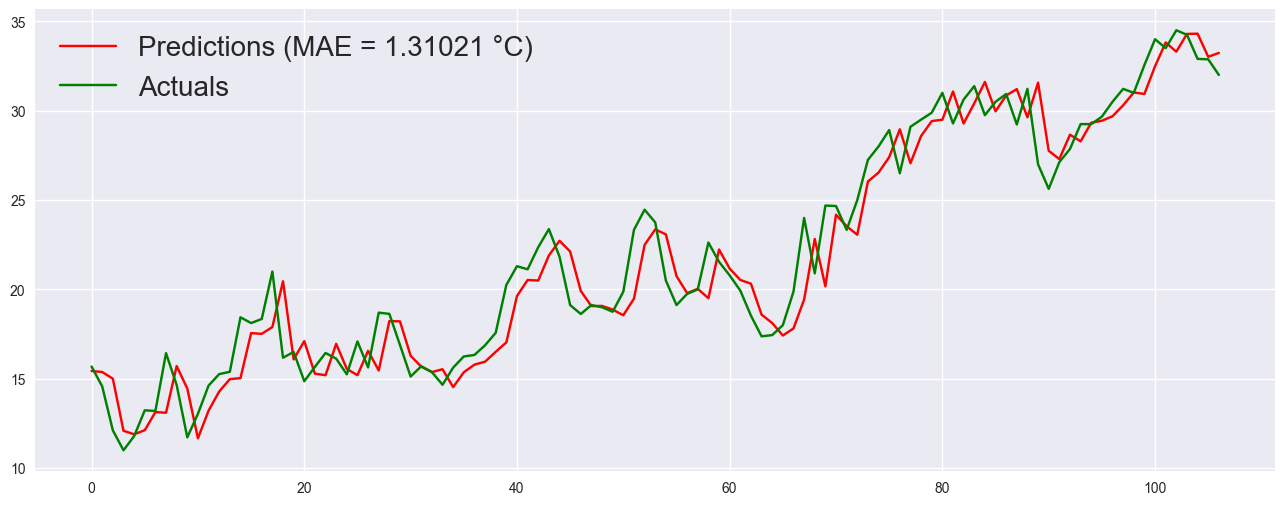

In [52]:
visualize_predictions(preds_acts_rnn)

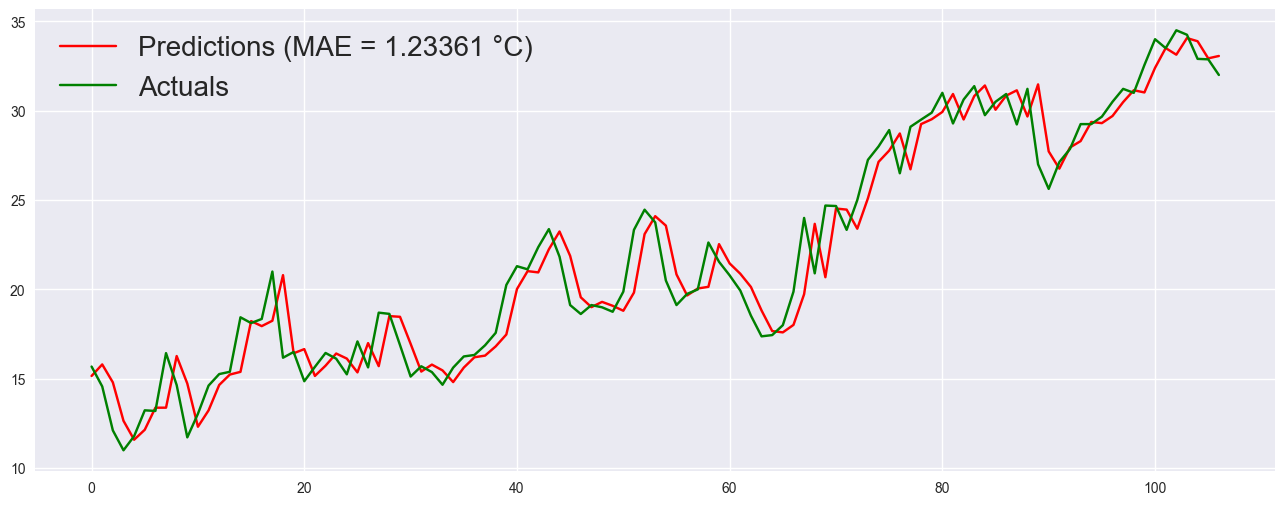

In [53]:
visualize_predictions(preds_acts_gru)

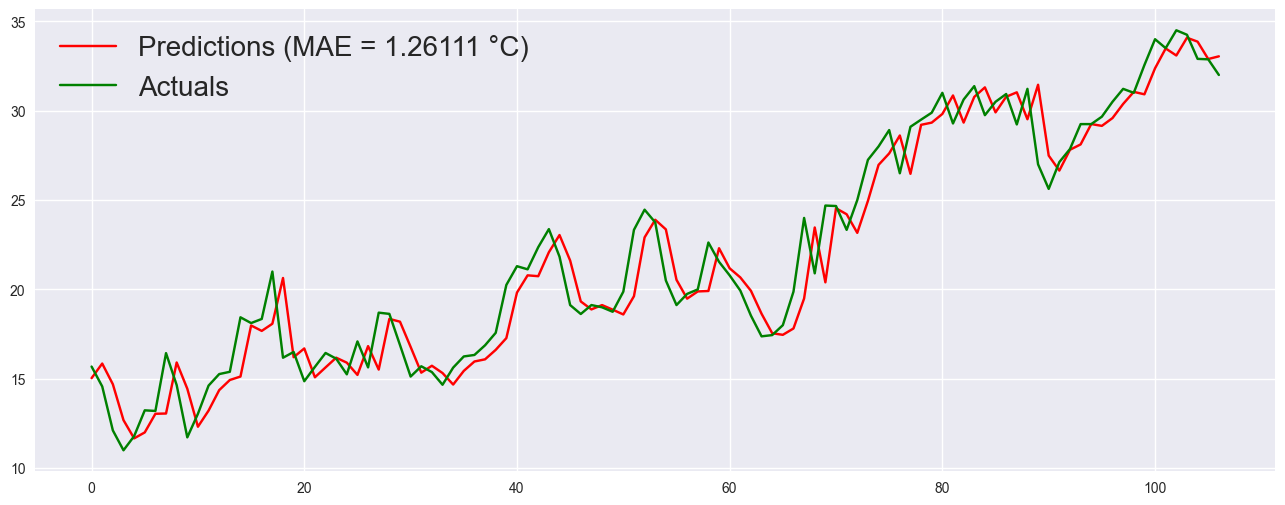

In [54]:
visualize_predictions(preds_acts_lstm)

## Вывод

Модель GRU показала наилучшие результаты — примерно 1.23 $^{\circ}C$. Модель LSTM показала худшие результаты по сравнению с GRU, несмотря на свою более сложную архитектуру и большее количество обучаемых параметров. Использование модели LSTM в данной задаче нецелесообразно, поскольку она не только усложняет процесс обучения, но и уступает GRU по качеству предсказаний. Таким образом, модель GRU является оптимальным выбором для этой задачи, так как она демонстрирует хорошие результаты и обладает разумным количеством обучаемых параметров.

# Точечное прогнозирование температуры на следующий день на основе многомерного временного ряда

Теперь будем обучать модели, используя следующие признаки — температуру (`meantemp`), влажность (`humidity`) и атмосферное давление (`meanpressure`). Применим те же преобразования к данным, которые были выполнены для одномерного временного ряда.

In [55]:
features_considered = ['meantemp', 'meanpressure', 'humidity']

In [56]:
dataset_mul = df[:-1][features_considered]
dataset_mul = pd.DataFrame(dataset_mul)
data_mul = dataset_mul.values

dataset_mul_test = df_test[features_considered]
dataset_mul_test = pd.DataFrame(dataset_mul_test)
data_mul_test = dataset_mul_test.values

In [57]:
scaler_mul = StandardScaler()
scaler_mul.fit(np.array(data_mul[:train_size]))

scaled_data_mul = scaler_mul.transform(data_mul)
scaled_data_mul_test = scaler_mul.transform(data_mul_test)

In [58]:
# Создание обучающей выборки на основе многомерного ряда
x_train_mul, y_train_mul = generate_data(scaled_data_mul, scaled_data_mul[:, 0], 0,
                                         train_size, PAST_HISTORY,
                                         FUTURE_TARGET, STEP,
                                         single_step=True)

# Создание валидационной выборки на основе многомерного ряда
x_val_mul, y_val_mul = generate_data(scaled_data_mul, scaled_data_mul[:, 0], train_size,
                                     None, PAST_HISTORY,
                                     FUTURE_TARGET, STEP,
                                     single_step=True)

# Создание тестовой выборки на основе многомерного ряда
x_test_mul, y_test_mul = generate_data(scaled_data_mul_test, scaled_data_mul_test[:, 0], 0,
                                       None, PAST_HISTORY,
                                       FUTURE_TARGET, STEP,
                                       single_step=True)

In [59]:
model_rnn_mul = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=8,
                              input_shape=x_train_mul.shape[-2:],
                              ),
    tf.keras.layers.Dense(units=1)
])

model_gru_mul = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units=8,
                        input_shape=x_train_mul.shape[-2:],
                        ),
    tf.keras.layers.Dense(units=1)
])

model_lstm_mul = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=8,
                         input_shape=x_train_mul.shape[-2:],
                         ),
    tf.keras.layers.Dense(units=1)
])

# Компиляция модели с использованием SimpleRNN
model_rnn_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Компиляция модели с использованием GRU
model_gru_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Компиляция модели с использованием LSTM
model_lstm_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [60]:
history_rnn_mul = model_rnn_mul.fit(x_train_mul, y_train_mul, epochs=EPOCHS, validation_data=(x_val_mul, y_val_mul))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2645 - val_loss: 1.7960
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7380 - val_loss: 1.3190
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1970 - val_loss: 0.7923
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6568 - val_loss: 0.4698
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4473 - val_loss: 0.3827
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3886 - val_loss: 0.3507
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3512 - val_loss: 0.3267
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3256 - val_loss: 0.3107
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3058 - val_loss: 0.2967
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892 - val_loss: 0.2862
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2752 - val_loss: 0.2784
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

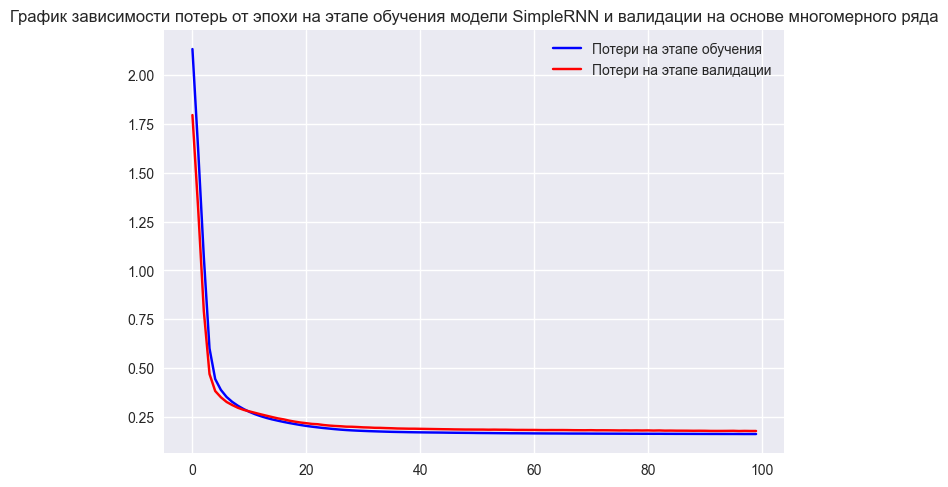

In [61]:
plot_train_history(history_rnn_mul, 'График зависимости потерь от эпохи на этапе обучения модели SimpleRNN и валидации на основе многомерного ряда')

In [62]:
history_gru_mul = model_gru_mul.fit(x_train_mul, y_train_mul, epochs=EPOCHS, validation_data=(x_val_mul, y_val_mul))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5944 - val_loss: 0.3696
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3163 - val_loss: 0.2177
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2196 - val_loss: 0.2047
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2096 - val_loss: 0.2000
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2018 - val_loss: 0.1953
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1961 - val_loss: 0.1918
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1919 - val_loss: 0.1891
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1882 - val_loss: 0.1863
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1853 - val_loss: 0.1843
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1827 - val_loss: 0.1823
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1810 - val_loss: 0.1807
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

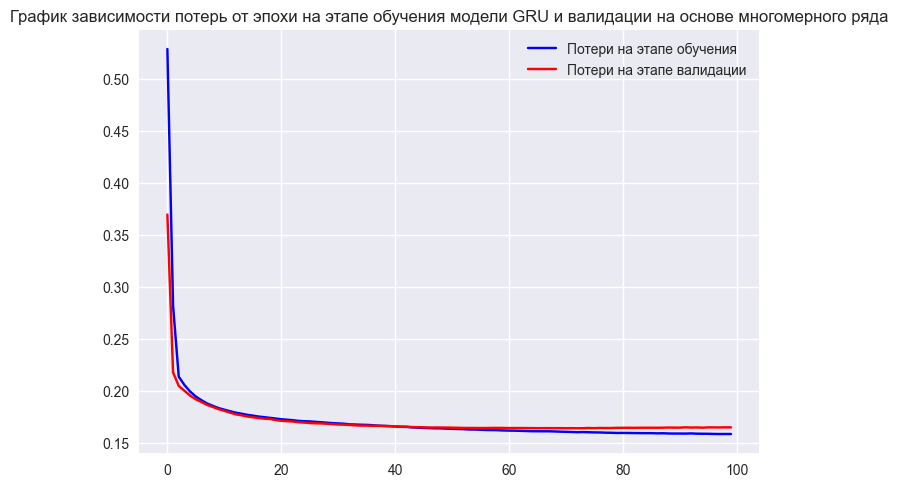

In [63]:
plot_train_history(history_gru_mul, 'График зависимости потерь от эпохи на этапе обучения модели GRU и валидации на основе многомерного ряда')

In [64]:
history_lstm_mul = model_lstm_mul.fit(x_train_mul, y_train_mul, epochs=EPOCHS, validation_data=(x_val_mul, y_val_mul))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4221 - val_loss: 0.3659
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3393 - val_loss: 0.3000
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2880 - val_loss: 0.2652
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2582 - val_loss: 0.2499
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2419 - val_loss: 0.2370
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2284 - val_loss: 0.2285
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2197 - val_loss: 0.2205
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2131 - val_loss: 0.2168
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2083 - val_loss: 0.2135
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2048 - val_loss: 0.2093
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2018 - val_loss: 0.2089
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

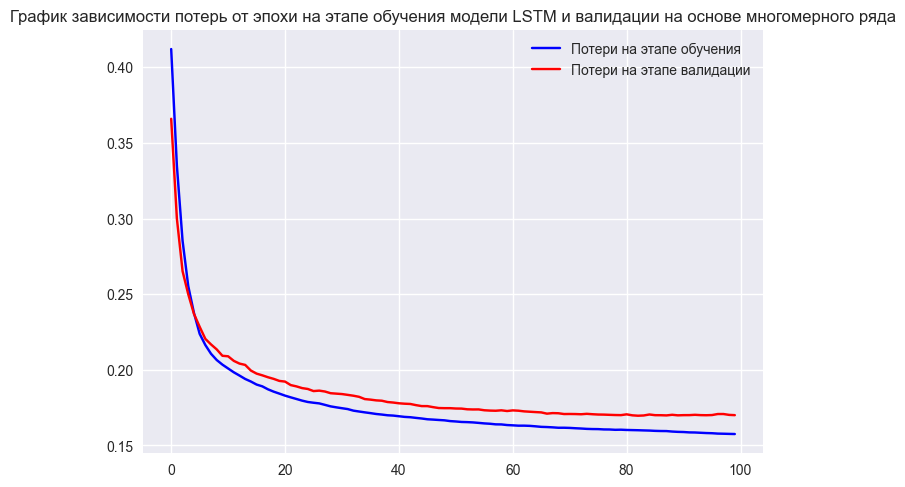

In [65]:
plot_train_history(history_lstm_mul, 'График зависимости потерь от эпохи на этапе обучения модели LSTM и валидации на основе многомерного ряда')

В результате обучения рекуррентных нейронных сетей SimpleRNN, LSTM и GRU тоже удалось достичь значения функции потерь MAE 0.15 (1.11 $^{\circ}C$) на обучающей выборке и 0.16-0.17 (1.184-1.258 $^{\circ}C$) на валидационной выборке. Таким образом, можно сделать вывод, что дальнейшее уменьшение функции потерь на этих данных вряд ли возможно, поскольку были перепробованы различные гиперпараметры, и это лучшие результаты, которых удалось достичь.

In [66]:
predictions_rnn_mul = model_rnn_mul.predict(x_test_mul, verbose=0)
predictions_rnn_mul = (predictions_rnn_mul * scaler_mul.scale_[0]) + scaler_mul.mean_[0]

predictions_gru_mul = model_gru_mul.predict(x_test_mul, verbose=0)
predictions_gru_mul = (predictions_gru_mul * scaler_mul.scale_[0]) + scaler_mul.mean_[0]

predictions_lstm_mul = model_lstm_mul.predict(x_test_mul, verbose=0)
predictions_lstm_mul = (predictions_lstm_mul * scaler_mul.scale_[0]) + scaler_mul.mean_[0]

In [67]:
y_test_mul = (y_test_mul * scaler_mul.scale_[0]) + scaler_mul.mean_[0]

In [68]:
preds_acts_rnn_mul = pd.DataFrame(data={'Predictions':predictions_rnn_mul.flatten(), 'Actuals':y_test_mul.flatten()})

preds_acts_gru_mul = pd.DataFrame(data={'Predictions':predictions_gru_mul.flatten(), 'Actuals':y_test_mul.flatten()})

preds_acts_lstm_mul = pd.DataFrame(data={'Predictions':predictions_lstm_mul.flatten(), 'Actuals':y_test_mul.flatten()})

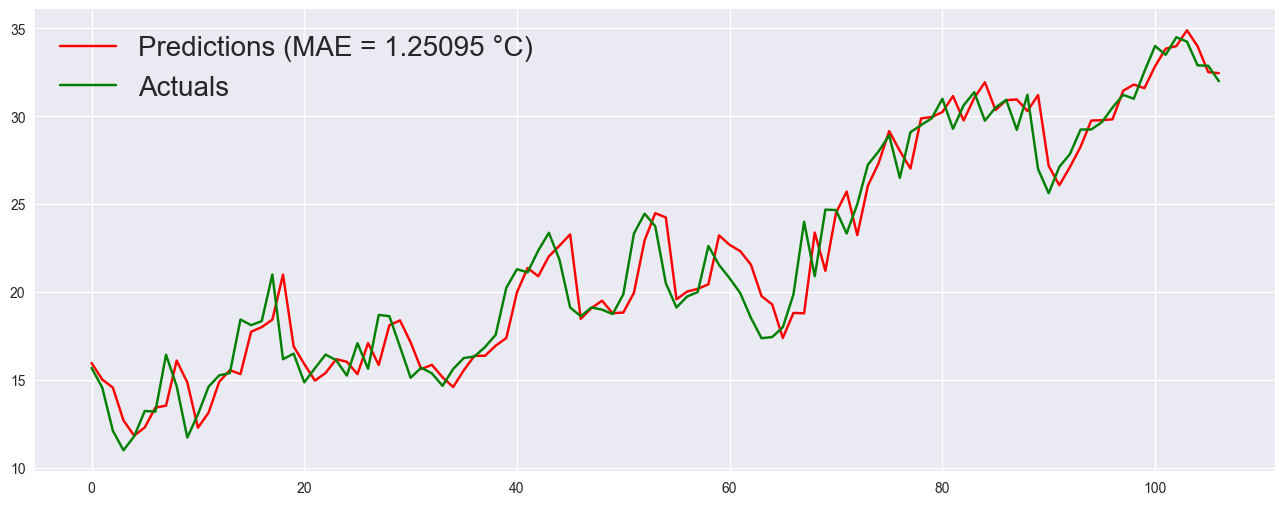

In [69]:
visualize_predictions(preds_acts_rnn_mul)

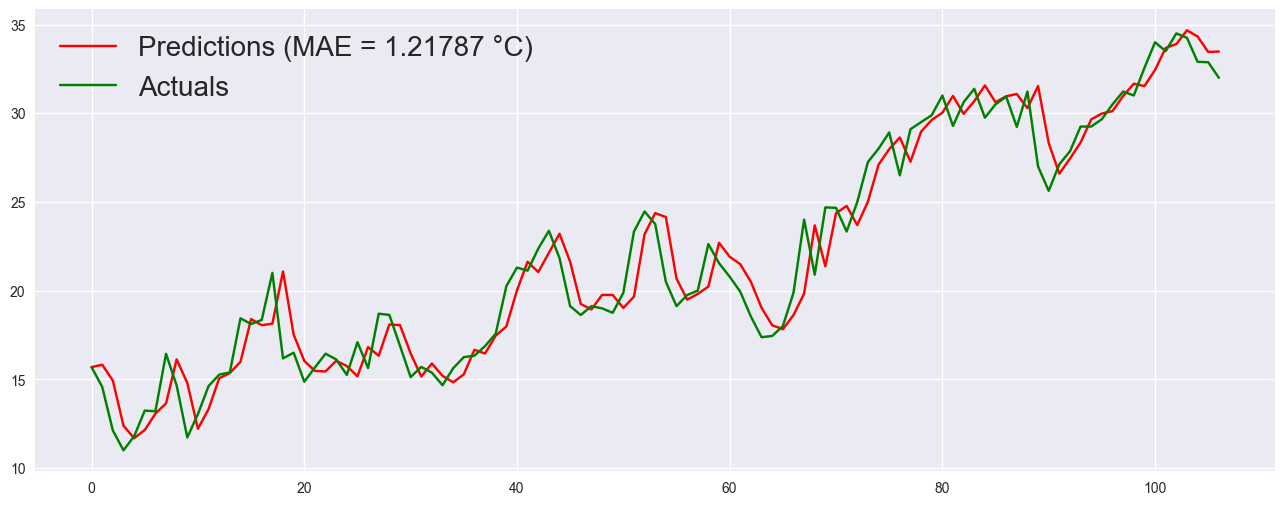

In [70]:
visualize_predictions(preds_acts_gru_mul)

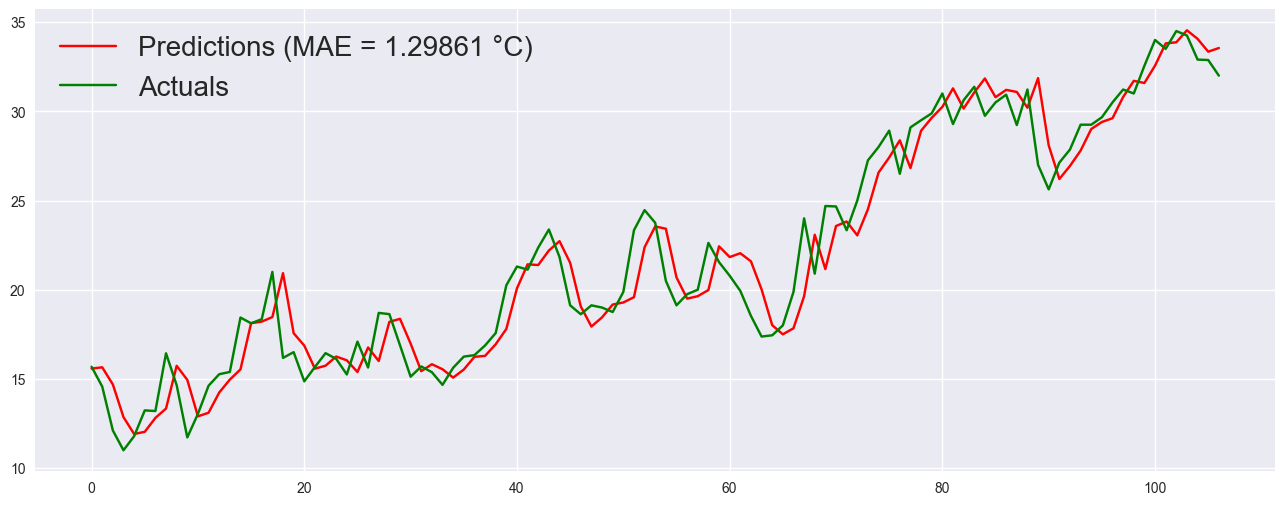

In [71]:
visualize_predictions(preds_acts_lstm_mul)

## Вывод

На основе исследования можно сделать вывод, что на текущем наборе данных лучшее, чего можно добиться — это средняя абсолютная ошибка, равная 1.22 $^{\circ}C$. Это значит, что модель GRU в среднем ошибается на 1.22 $^{\circ}C$ от истинных значений. Модель SimpleRNN работает значительно хуже, однако она имеет значительно меньше параметров по сравнению с моделями LSTM и GRU. Она подходит только для задач с очень простыми закономерностями. Модель LSTM в данном случае проигрывает по всем параметрам: она сложнее, имеет больше обучаемых параметров и работает хуже, чем GRU. Однако это относится только к текущему набору данных. В других задачах модель LSTM может работать значительно лучше, чем GRU.